# Customer Segmentation using Clustering
### Completed by Chantel Clark
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel('./WineKMC.xlsx', sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
merged = df_offers.merge(df_transactions, how='outer', on='offer_id')
df = pd.pivot_table(merged, index='customer_name', columns='offer_id', values='n', fill_value=0)

In [5]:
df.reset_index(inplace=True)
df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 columns) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Smaller $SS$ values represent better clusterings because this means that there is less distance between each point and the closest centroid. The data points will be bunched closer together.

In [6]:
# your turn
x_cols = df[df.columns[1:]]
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [7]:
from sklearn.cluster import KMeans
import numpy as np

ks = range(2,11)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(x_cols)
    inertias.append(model.inertia_)

([<matplotlib.axis.XTick at 0x1c5939cd148>,
 <a list of 9 Text xticklabel objects>)

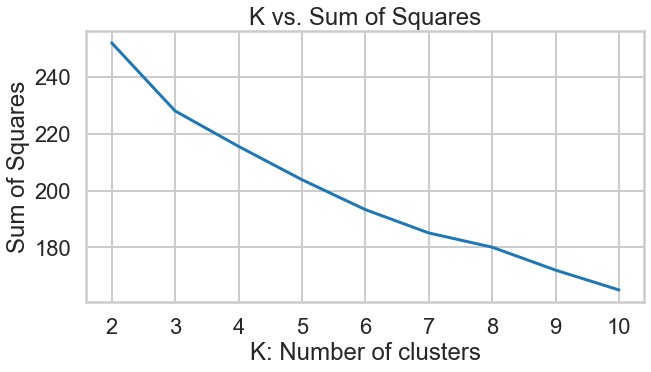

In [8]:
# Create a line plot of k vs. Sum of Squares
from matplotlib.pyplot import figure

figure(figsize=(10,5))
plt.plot(ks, inertias)
plt.title('K vs. Sum of Squares')
plt.xlabel('K: Number of clusters')
plt.ylabel('Sum of Squares')
plt.xticks(np.arange(2,11))

In [9]:
# For k = 3

model = KMeans(n_clusters=3, random_state=10)
model.fit(x_cols)
df['cluster'] = model.predict(x_cols)

In [10]:
cluster_ns = df['cluster'].value_counts().sort_index()
cluster_ns

0    46
1    37
2    17
Name: cluster, dtype: int64

Text(0, 0.5, 'Number of points')

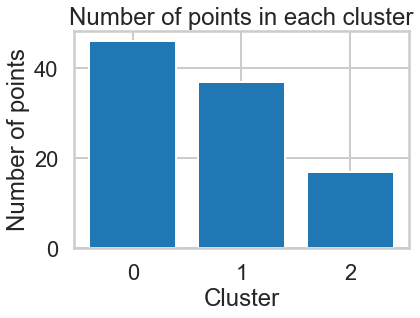

In [11]:
plt.bar(cluster_ns.index, cluster_ns)
plt.title('Number of points in each cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of points')

<div class="alert alert-block alert-warning">
    <b>Answer:</b>
It was difficult to tell exactly where the 'elbow' in the line graph (K vs. Sum of Squares) was because the slope of the line did not change much between the different number of cluster; there was no obvious bending point. Another person might have chosen 7 clusters.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


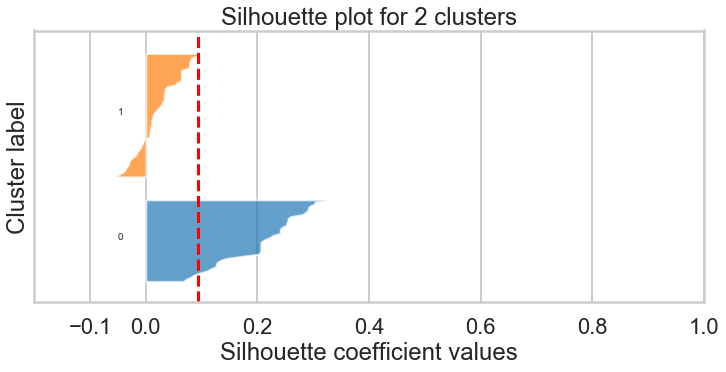

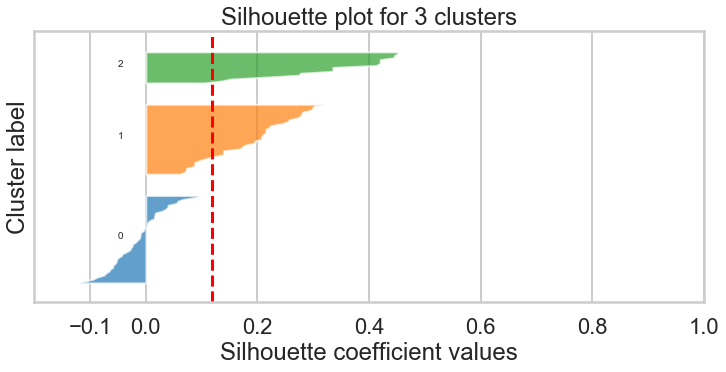

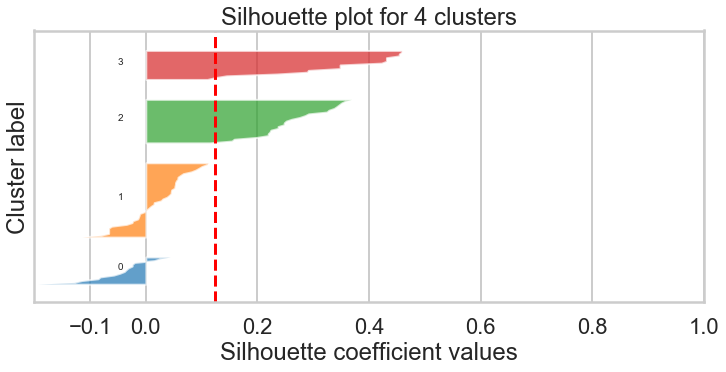

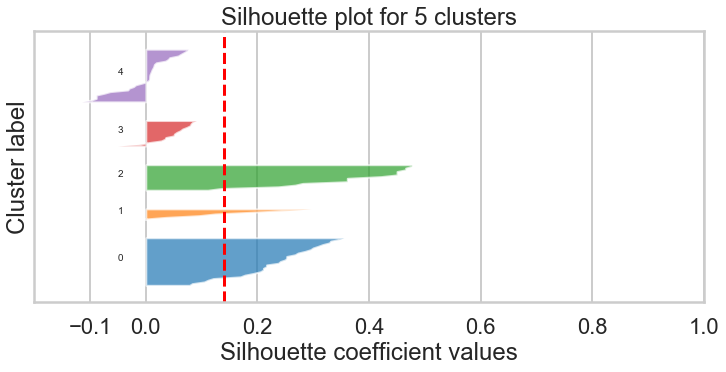

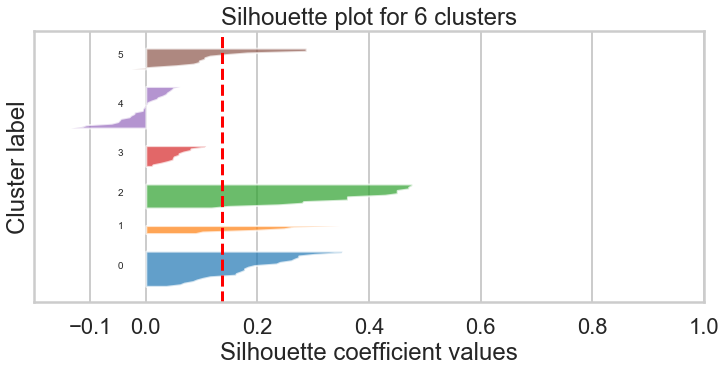

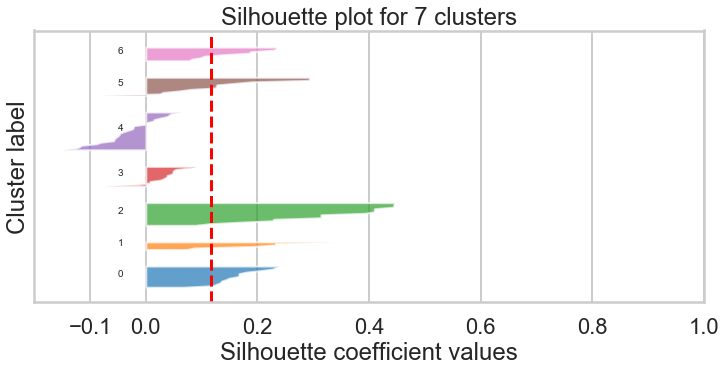

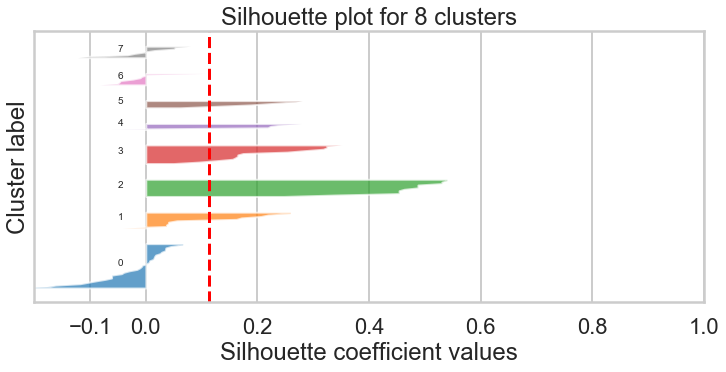

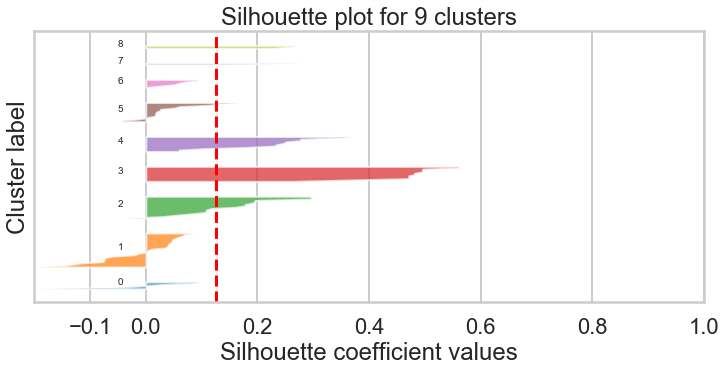

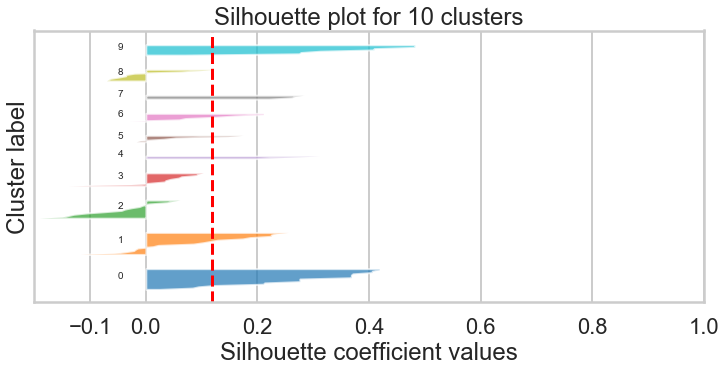

In [12]:
# Your turn.
from sklearn.metrics import silhouette_score, silhouette_samples

k_range = range(2,11)
silhouette_avgs = []

for k in k_range:
    # Create a plot
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5)
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (k + 1) * 10])
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot for " +  str(k) + " clusters")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

Text(0, 0.5, 'Average Silhouette Score')

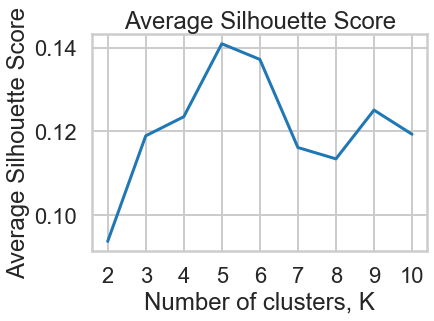

In [13]:
# Plot the silhouette average score for each K

plt.plot(k_range, silhouette_avgs)
plt.xticks(np.arange(2,11))
plt.title('Average Silhouette Score')
plt.xlabel('Number of clusters, K')
plt.ylabel('Average Silhouette Score')

<div class="alert alert-block alert-warning">
    <b>Answer:</b>
This analysis suggests that it would be best to use 5 clusters (as opposed to 3 clusters from the previous KMeans section), because this is where the highest average silhouette score of 0.14 occured. However, 0.14 is a low score, and scores below 0.25 mean that no substantial structure has been found.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [14]:
#your turn
from sklearn.decomposition import PCA

# Instantiate PCA model
pca = PCA(n_components=2)

# Fit and transform data, get x and y PCA coordinate
df['x'] = pca.fit_transform(x_cols)[:,0]
df['y'] = pca.fit_transform(x_cols)[:,1]
#df.head()

In [15]:
# Select only these 4 columns
new_df = df[['customer_name', 'x', 'y', 'cluster']]
new_df.head()

offer_id,customer_name,x,y,cluster
0,Adams,1.007580,0.108215,1
1,Allen,-0.287539,0.044715,0
2,Anderson,-0.392032,1.038391,2
3,Bailey,0.699477,-0.022542,1
4,Baker,0.088183,-0.471695,0


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
customer_name    100 non-null object
x                100 non-null float64
y                100 non-null float64
cluster          100 non-null int32
dtypes: float64(2), int32(1), object(1)
memory usage: 2.9+ KB


Text(53.722128472222224, 0.5, 'Component 2')

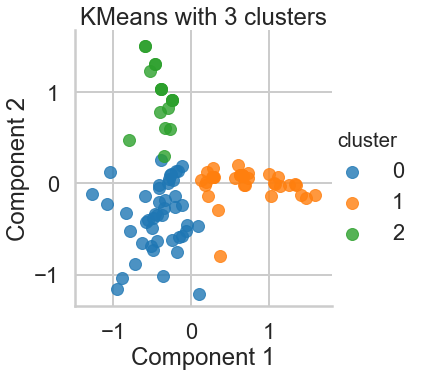

In [17]:
# Scatter plot of the data, color coded by cluster
sns.lmplot('x', 'y', hue='cluster', data=new_df, fit_reg=False)
plt.title('KMeans with 3 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Text(57.81221006944443, 0.5, 'Component 2')

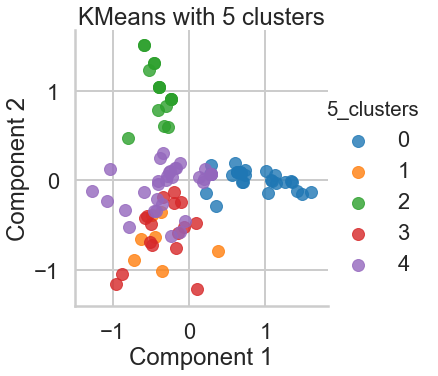

In [18]:
# Let's compare this to using 5 clusters

# For k = 5

model = KMeans(n_clusters=5, random_state=10)
model.fit(x_cols)
df['5_clusters'] = model.predict(x_cols)
sns.lmplot('x', 'y', hue='5_clusters', data=df, fit_reg=False)
plt.title('KMeans with 5 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

<div class="alert alert-block alert-warning">
Visualizing the data using PCA plots, it appears that the best number of clusters, K, is 3. You can see that when there are 5 clusters that there is a lot of overlap of red, orange and purple points. For this set of data, the best way to find K was through using the Elbow Sum of Squares method.

In [19]:
# Merge df_transactions with new_df
df_transactions = pd.merge(df_transactions, new_df)
df_transactions.head()

,customer_name,offer_id,n,x,y,cluster
0,Smith,2,1,-0.300227,0.829765,2
1,Smith,24,1,-0.300227,0.829765,2
2,Johnson,17,1,-0.461726,1.313485,2
3,Johnson,24,1,-0.461726,1.313485,2
4,Johnson,26,1,-0.461726,1.313485,2


In [20]:
# Merge df_transactions with df_offers
merged = pd.merge(df_transactions, df_offers)
merged.head()

,customer_name,offer_id,n,x,y,cluster,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,-0.300227,0.829765,2,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,-0.403273,0.786296,2,January,Pinot Noir,72,17,France,False
2,Martin,2,1,-0.382241,0.254034,0,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,-0.839578,-0.328823,0,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,-0.522247,1.231406,2,January,Pinot Noir,72,17,France,False


In [21]:
varietal_df = pd.DataFrame(merged.groupby(merged.cluster).varietal.value_counts())
varietal_df.rename(columns={'varietal':'num'}, inplace=True)
# Multiindex dataframe to flat dataframe
varietal_df.reset_index(level=['cluster', 'varietal'], inplace=True)
varietal_df.head()

,cluster,varietal,num
0,0,Champagne,74
1,0,Cabernet Sauvignon,30
2,0,Prosecco,21
3,0,Chardonnay,13
4,0,Malbec,12


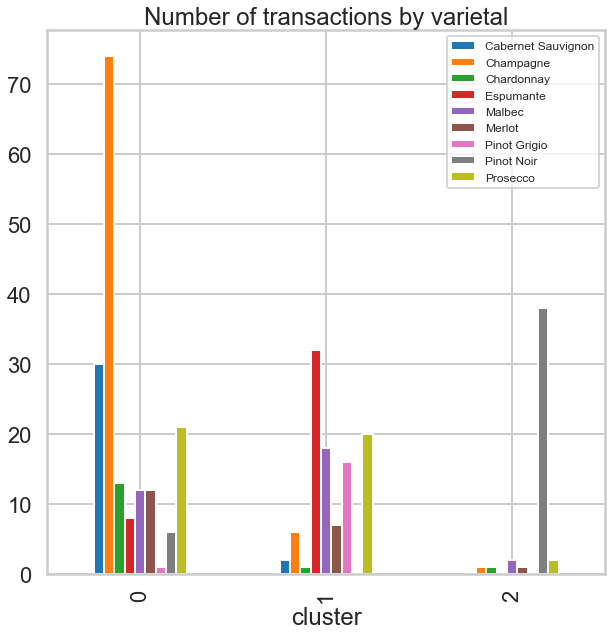

In [22]:
# Grouped bar plot
varietal_df.pivot("cluster", "varietal", "num").plot(kind='bar', figsize=(10,10))
plt.title('Number of transactions by varietal')
plt.legend(fontsize=12)


<div class="alert alert-block alert-warning">
    Cluster 0 orders the most Champagne and Cabernet Sauvignon, Cluster 1 orders the most Espumante and Malbec, and Cluster 2 orders the most Pinot Noir.

In [23]:

origins = pd.DataFrame(merged.groupby(merged.cluster).origin.value_counts())
origins.rename(columns={'origin':'num'}, inplace=True)
origins.reset_index(level=['cluster', 'origin'], inplace=True)
origins.head()

,cluster,origin,num
0,0,France,82
1,0,Chile,29
2,0,Italy,12
3,0,New Zealand,11
4,0,Oregon,10


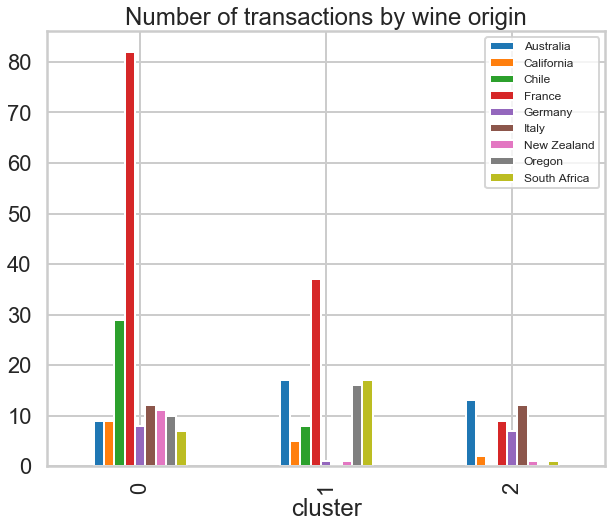

In [24]:
# Grouped bar plot of 'origin'
origins.pivot('cluster', 'origin', 'num').plot(kind='bar', figsize=(10,8))
plt.title('Number of transactions by wine origin')
plt.legend(fontsize=12)

<div class="alert alert-block alert-warning">
    Cluster 0 orders wine from a variety of regions, but with the largest amount from France, and Chile coming in as a distant second. Cluster 1 orders most of their wine from France as well, but less than half the amount of transactions in Cluster 0. The next most popular wine origins for Cluster 1 are Australia, Oregon and South Africa. Cluster 2 has the least amount of transactions with the majority of the transaction for wines from Australia, France, Germany and Italy. 

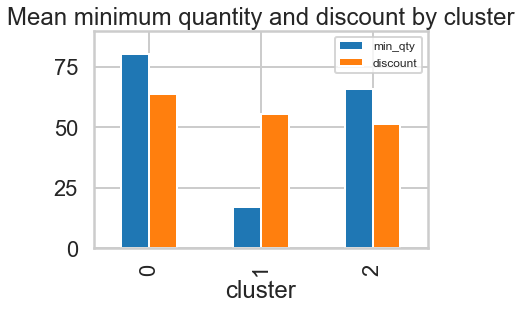

In [25]:
# Mean of min_qty and discount by cluster
offer_df = pd.DataFrame(merged.groupby(merged.cluster)[['min_qty', 'discount']].mean())
offer_df.plot(kind='bar')
plt.title('Mean minimum quantity and discount by cluster')
plt.ylim(0,90)
plt.legend(loc=1, fontsize=12)

<div class="alert alert-block alert-warning">
    Cluster 0 tends to order the most wine with the largest discounts, they are buying in bulk. Cluster 1 are the people who take advantage of offers with much lower minimum quantity requirements. Cluster 2 also appears to buy in bulk with the mean minimum quantity lafter than 60 bottles.  
    

<div class="alert alert-block alert-warning">
In summary, Cluster 0 and 2 are likely to represent transactions from businesses or large events because the minimum quantity is on the higher side. Cluster 0 are the champagne and cabernet sauvignon bulk purchases, and Cluster 2 orders are usually pinot noir in bulk. Cluster 1 are the smaller orders, that are most likely bought by individuals.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

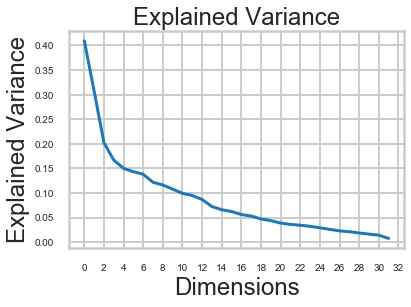

In [26]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
ax = plt.gca()

explained_var = pca.explained_variance_
plt.plot(explained_var)
plt.title('Explained Variance')
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(0,34,2))

ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

<div class="alert alert-block alert-warning">
    <b>Answer:</b>
    There is a large change in variance at 3 or 4 dimensions, so the optimal number of dimensions is probably 3 or 4.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [27]:
# Your turn

comps = {} # create a dictionary to store best scores

### 1. Affinity Propagation
from sklearn.cluster import AffinityPropagation

cluster = AffinityPropagation().fit(x_cols)
labels = cluster.labels_
cluster_centers_indices = cluster.cluster_centers_indices_ 
df['affinity_cluster'] = labels

print(len(cluster_centers_indices))

14


In [28]:
df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,cluster,x,y,5_clusters,affinity_cluster
0,Adams,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1.007580,0.108215,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-0.287539,0.044715,4,10
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,-0.392032,1.038391,2,6
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0.699477,-0.022542,0,3
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0.088183,-0.471695,3,3


Text(66.0904045138889, 0.5, 'Component 2')

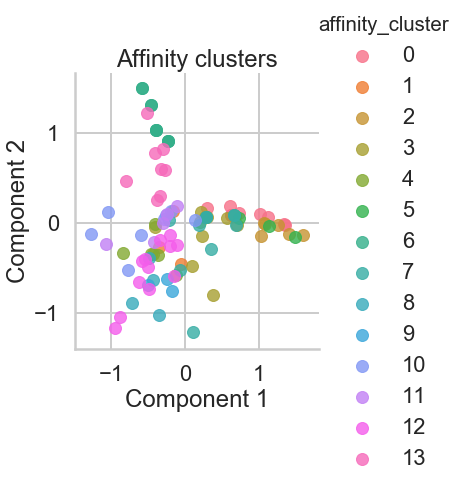

In [29]:
sns.lmplot('x', 'y', hue='affinity_cluster', data=df, fit_reg=False)
plt.title('Affinity clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [30]:
silhouette_avg = silhouette_score(x_cols, labels)
print(silhouette_avg)

comps['Affinity Propagation'] = silhouette_avg

0.12346523604478911


In [31]:
### 2. Spectral Clustering
from sklearn.cluster import SpectralClustering

ks = range(2,11)
best_score = 0

for k in ks:
    sc_cluster = SpectralClustering(n_clusters = k, random_state=10)
    sc_cluster.fit(x_cols)
    sc_labels = sc_cluster.labels_
    silhouette_avg = silhouette_score(x_cols, sc_labels)
    print('K=', k, 'silhouette average =', silhouette_avg)
    if silhouette_avg > best_score: 
        best_score = silhouette_avg
        best_k = k

print('The best score was', best_score, 'when k =', best_k)
comps['Spectral Clustering'] = best_score

K= 2 silhouette average = 0.07631909829627558
K= 3 silhouette average = 0.10611539040197304
K= 4 silhouette average = 0.08627893400734331
K= 5 silhouette average = 0.09915711813463922
K= 6 silhouette average = 0.09847779745663406
K= 7 silhouette average = 0.08299798621366726
K= 8 silhouette average = 0.10795290206617342
K= 9 silhouette average = 0.09119269817131899
K= 10 silhouette average = 0.08294476827044912
The best score was 0.10795290206617342 when k = 8


Text(53.91819097222222, 0.5, 'Component 2')

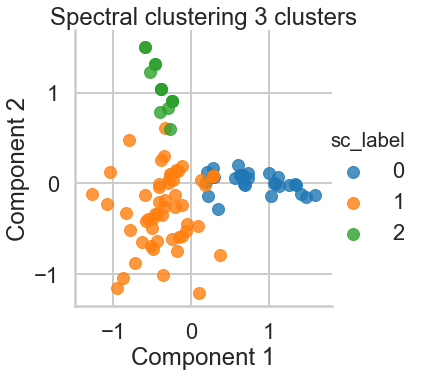

In [32]:
sc_cluster = SpectralClustering(n_clusters = 3, random_state=10)
sc_cluster.fit(x_cols)
sc_labels = sc_cluster.labels_
df['sc_label'] = sc_labels
sns.lmplot('x', 'y', hue='sc_label', data=df, fit_reg=False)
plt.title('Spectral clustering 3 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Text(53.91819097222222, 0.5, 'Component 2')

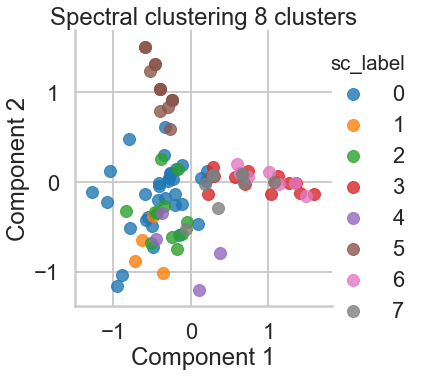

In [33]:
sc_cluster = SpectralClustering(n_clusters = 8, random_state=10)
sc_cluster.fit(x_cols)
sc_labels = sc_cluster.labels_
df['sc_label'] = sc_labels
sns.lmplot('x', 'y', hue='sc_label', data=df, fit_reg=False)
plt.title('Spectral clustering 8 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

<div class="alert alert-block alert-warning">
This doesn't seem to look like a better model than the previous model where k=3, but the score is actually better when k=8. There is a lot of overlapping of the groups in the 2D plane - perhaps this grouping would make more sense in 3 or 4 dimensions (as explained variance was discussed in previous section). 

In [34]:
### 3. Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

# Try different n_clusters

ks = range(2,11)
best_score = 0

for k in ks:
    agg_cluster = AgglomerativeClustering(n_clusters = k)
    agg_cluster.fit(x_cols)
    agg_labels = agg_cluster.labels_
    silhouette_avg = silhouette_score(x_cols, agg_labels)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k
        
print('The best score was', best_score, 'when k =', best_k)
comps['Agglomerative Clustering'] = best_score

The best score was 0.15578053718604024 when k = 8


silhouette average = 0.15578053718604024


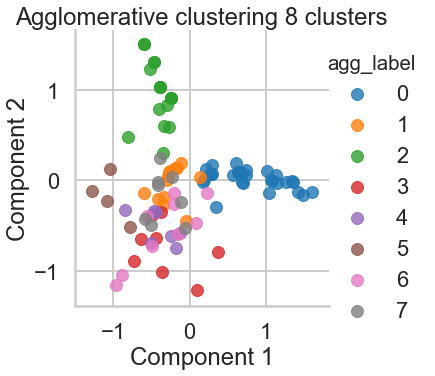

In [35]:
# Visualize agglomerative clustering with 8 clusters
agg_cluster = AgglomerativeClustering(n_clusters = 8)
agg_cluster.fit(x_cols)
agg_labels = agg_cluster.labels_
df['agg_label'] = agg_labels
sns.lmplot('x', 'y', hue='agg_label', data=df, fit_reg=False)
plt.title('Agglomerative clustering 8 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

silhouette_avg = silhouette_score(x_cols, agg_labels)
print('silhouette average =', silhouette_avg)

silhouette average = 0.11625878863607858


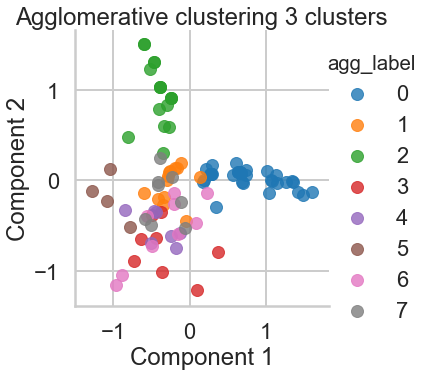

In [36]:
# Compare to 3 clusters
agg_cluster = AgglomerativeClustering(n_clusters = 3)
agg_cluster.fit(x_cols)
agg_labels = agg_cluster.labels_
#df['agg_label'] = agg_labels
sns.lmplot('x', 'y', hue='agg_label', data=df, fit_reg=False)
plt.title('Agglomerative clustering 3 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

silhouette_avg = silhouette_score(x_cols, agg_labels)
print('silhouette average =', silhouette_avg)

In [37]:
### 4. DBSCAN
from sklearn.cluster import DBSCAN

eps_list = [0.3, 0.5, 0.7, 1.2, 1.5]
min_list = [3, 4, 5, 6, 7]
best_score = 0

for eps in eps_list:
    for min_samples in min_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(x_cols)
        db_label = dbscan.labels_
        # Enter loop when there is more than one label
        if len(set(db_label)) > 1: 
            silhouette_avg = silhouette_score(x_cols, db_label)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print('The best score is', best_score, 'when eps =', best_eps, 'and min_samples =', best_min_samples)
comps['DBSCAN'] = best_score

The best score is 0.13212401098509616 when eps = 1.5 and min_samples = 3


Text(55.355982638888875, 0.5, 'Component 2')

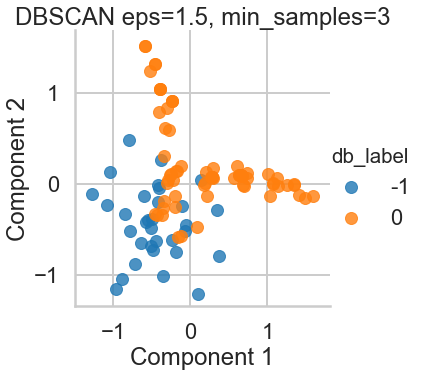

In [38]:
dbscan = DBSCAN(eps=1.5, min_samples=3).fit(x_cols)
db_label = dbscan.labels_
df['db_label'] = db_label
sns.lmplot('x', 'y', hue='db_label', data=df, fit_reg=False)
plt.title('DBSCAN eps=1.5, min_samples=3')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Text(55.355982638888875, 0.5, 'Component 2')

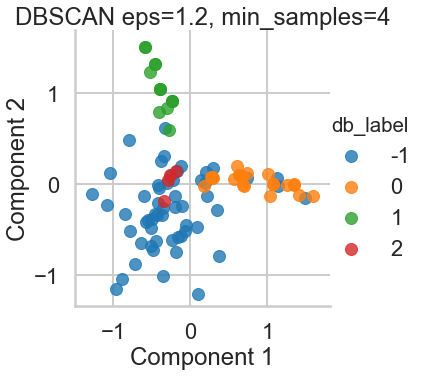

In [39]:
dbscan = DBSCAN(eps=1.2, min_samples=4).fit(x_cols)
db_label = dbscan.labels_
df['db_label'] = db_label
sns.lmplot('x', 'y', hue='db_label', data=df, fit_reg=False)
plt.title('DBSCAN eps=1.2, min_samples=4')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [40]:
silhouette_avg = silhouette_score(x_cols, db_label)
print('silhouette average =', silhouette_avg)

silhouette average = 0.041771182765493825


In [41]:
df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,31,32,cluster,x,y,5_clusters,affinity_cluster,sc_label,agg_label,db_label
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,1,1.007580,0.108215,0,0,6,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,-0.287539,0.044715,4,10,0,1,2
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,0,2,-0.392032,1.038391,2,6,5,2,1
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,1,0.699477,-0.022542,0,3,3,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,1,0,0,0.088183,-0.471695,3,3,0,6,-1


In [42]:
# Compare the silhouette scores
print(comps)

{'Affinity Propagation': 0.12346523604478911, 'Spectral Clustering': 0.10795290206617342, 'Agglomerative Clustering': 0.15578053718604024, 'DBSCAN': 0.13212401098509616}


<div class="alert alert-block alert-warning">
    <b>Answer:</b> The silhouette scores were all below 0.25, which indicate that there is no substantial structure to this data. The agglomerative clustering probably had the highest silhouette score because the data is sparse, and requires many clusters to capture the structure of the data.

In [43]:
new_df2 = df[['customer_name', 'x', 'y', 'agg_label']]
new_df2.head()

offer_id,customer_name,x,y,agg_label
0,Adams,1.007580,0.108215,0
1,Allen,-0.287539,0.044715,1
2,Anderson,-0.392032,1.038391,2
3,Bailey,0.699477,-0.022542,0
4,Baker,0.088183,-0.471695,6


In [44]:
# Merge df_transactions with new_df
df_transactions2 = pd.merge(df_transactions, new_df2)
merged2 = pd.merge(df_transactions2, df_offers)
merged2.head()

,customer_name,offer_id,n,x,y,cluster,agg_label,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,-0.300227,0.829765,2,2,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,-0.403273,0.786296,2,2,January,Pinot Noir,72,17,France,False
2,Martin,2,1,-0.382241,0.254034,0,7,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,-0.839578,-0.328823,0,4,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,-0.522247,1.231406,2,2,January,Pinot Noir,72,17,France,False


In [45]:
varietal_df2 = pd.DataFrame(merged2.groupby(merged2.agg_label).varietal.value_counts())
varietal_df2.rename(columns={'varietal':'num'}, inplace=True)
# Multiindex dataframe to flat dataframe
varietal_df2.reset_index(level=['agg_label', 'varietal'], inplace=True)
varietal_df2.head()

,agg_label,varietal,num
0,0,Espumante,29
1,0,Malbec,17
2,0,Prosecco,17
3,0,Pinot Grigio,16
4,0,Merlot,6


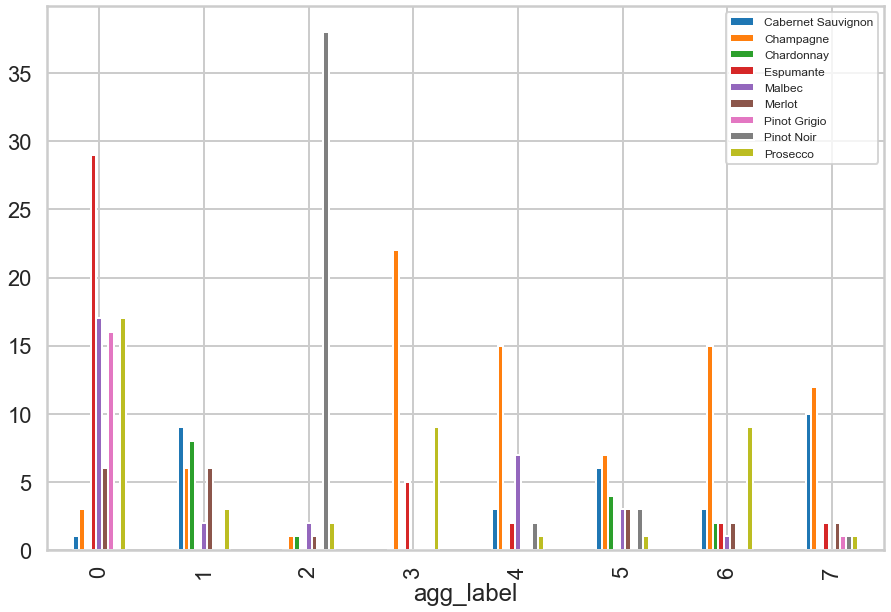

In [46]:
varietal_df2.pivot('agg_label', 'varietal', 'num').plot(kind='bar', figsize=(15,10))
plt.legend(fontsize='large')

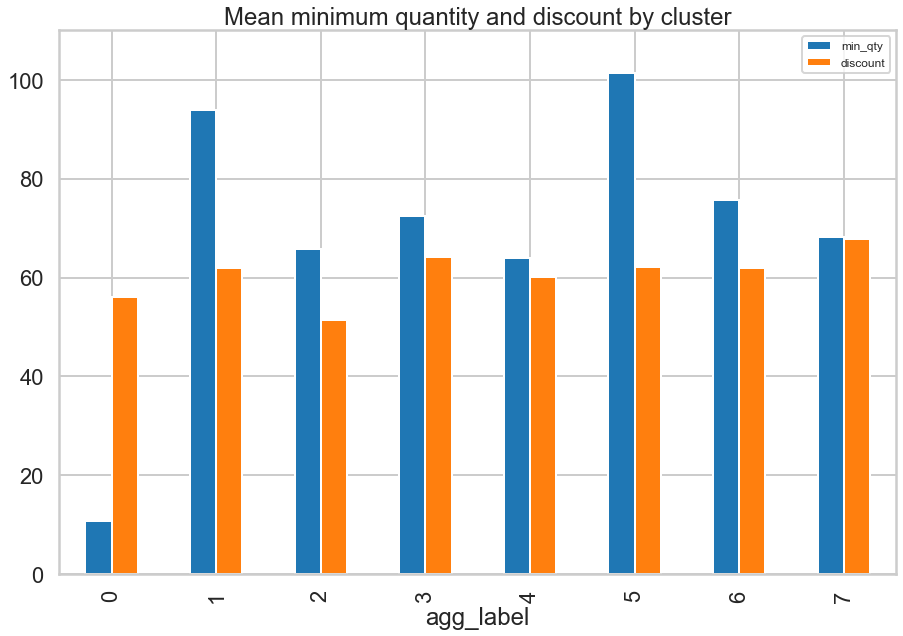

In [47]:
# Mean of min_qty and discount by cluster
offer_df = pd.DataFrame(merged2.groupby(merged2.agg_label)[['min_qty', 'discount']].mean())
offer_df.plot(kind='bar', figsize=(15,10))
plt.title('Mean minimum quantity and discount by cluster')
plt.ylim(0,110)
plt.legend(loc=1, fontsize=12)